In [8]:
# Import necessary PyTorch libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms


# Additional libraries for visualization and utilities
import matplotlib.pyplot as plt
import numpy as np
from unet import UNet
from unet_decoder import UNetDecoder
from echo import echo_sample

In [5]:
def get_device():
    """Selects the best available device for PyTorch computations.

    Returns:
        torch.device: The selected device.
    """

    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"using device: {device}")

using device: mps


In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor,Resize

transform = Compose([
    ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])


# Load the CelebA dataset
dataset = datasets.MNIST(root='./data', download=True, transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print("Data loaders created for training and validation.")

Data loaders created for training and validation.


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dims = latent_dims

        self.unet = UNet(
            n_channels=input_shape[0],
            n_classes=input_shape[0],  # Ensure the output channels match the input channels
            bilinear=True
        )

        # Output layers for mean and log variance
        self.out_mean = nn.Conv2d(input_shape[0], input_shape[0], kernel_size=1)
        self.out_log_var = nn.Conv2d(input_shape[0], input_shape[0], kernel_size=1)

    def forward(self, x):
        x = self.unet(x)
        f_x = torch.tanh(self.out_mean(x))
        log_var = torch.sigmoid(self.out_log_var(x))
        return f_x, log_var


In [9]:
class DiffusionModel(nn.Module):
    def __init__(self, input_shape,latent_dims, T=1000):
        super(DiffusionModel, self).__init__()
        self.input_shape = input_shape
        self.latent_dims = latent_dims 
        self.T = T
        self.encoder = Encoder(self.input_shape, self.latent_dims)
        self.decoder = UNetDecoder(n_channels=input_shape[0])

        # Define the noise schedule
        self.alpha = self.create_noise_schedule(T)

    def create_noise_schedule(self, T):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        return alphas_cumprod

    def forward(self, x):

        # Calculate the gaussian noise tensor
        batch_size = x.shape[0]
        f_x, sx_matrix = self.encoder(x)
        epsilon = echo_sample((f_x, sx_matrix)).detach()
        z = f_x + sx_matrix * epsilon
        
        del epsilon 
        
        torch.cuda.empty_cache()

        #sample a timestep t
        t = np.random.randint(0, self.T)
        # Retrieve noise scheduler alpha_T
        alpha_t = self.alpha[t]

        # Calculate square root alphas
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        
        # Perform the weighted sum
        x_t = sqrt_alpha_t * x + sqrt_one_minus_alpha_t * z

        torch.cuda.empty_cache()

        #Calculate the timestep tensor
        t = torch.tensor([t] * x_t.size(0), dtype=torch.long).to(x_t.device)

        # Perform the reconstruction process using Algorithm 2
        estimated_z = self.decoder(x_t,t)
        torch.cuda.empty_cache()
        return z, estimated_z

In [11]:
import os

def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth"):
    """Saves the model and optimizer state at the specified path."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Loads the model and optimizer state from the specified path."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {filename}, resuming training from epoch {epoch}")
        return epoch
    else:
        print(f"No checkpoint found at {filename}, starting from scratch.")
        return -1

In [12]:
import time  # Importing time to log the duration
from tqdm import tqdm


def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for data, _ in val_loader:
            data = data.to(device)
            z, estimated_z = model(data)
            reconstruction_loss = nn.functional.mse_loss(z, estimated_z)
            total_val_loss += reconstruction_loss.item()  # Accumulate the validation loss
    
    avg_val_loss = total_val_loss / len(val_loader)  # Calculate average loss
    return avg_val_loss

def train(model, optimizer, train_loader, device,start_epoch, num_epochs):
    model.train()

    for epoch in range(start_epoch+1, num_epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()  # Time tracking for the epoch

        print(f"Starting epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            data = data.to(device)

            # Forward pass
            z, estimated_z = model(data)
            total_loss = nn.functional.mse_loss(z, estimated_z)

            # Backward pass
            if not torch.isnan(total_loss).any():
                total_loss.backward()
            else:
                print(f"Warning: NaN detected in total_loss at batch {batch_idx+1}, skipping backward pass.")

            optimizer.step()  # Only step the optimizer every `accumulation_steps`
            optimizer.zero_grad()  # Reset gradients only after accumulation

            # Safe-guarding against NaN for epoch_loss
            if not torch.isnan(total_loss).any():
                epoch_loss += total_loss.item()
            else:
                print(f"NaN detected, not adding to epoch_loss at batch {batch_idx+1}")

        # Save the model checkpoint
        save_checkpoint(epoch, model, optimizer, filename="mnist_echo.pth")
        
        # Average loss after training for an epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds, Avg Loss: {avg_loss}")

        # Validation phase
        avg_val_loss = validate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] validation completed, Avg Validation Loss: {avg_val_loss}")

    return model


In [14]:
# Define the input shape
input_shape = (1, 28, 28)
latent_dims = latent_dims = [64, 128, 256, 512]

# Create an instance of Gaussian Diffusion model
model = DiffusionModel(input_shape,latent_dims).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Define the number of epochs and loss weights
num_epochs = 1

# Load the model training checkpoint
start_epoch = load_checkpoint(model, optimizer, filename="mnist_echo.pth")
print(f"The training ended in epoch number: {start_epoch}")

# Train the model
trained_model = train(model, optimizer, train_loader, device, start_epoch, num_epochs)

No checkpoint found at mnist_echo.pth, starting from scratch.
The training ended in epoch number: -1
Starting epoch 1/1


Checkpoint saved at epoch 0 to mnist_echo.pth
Epoch [1/1] completed in 535.51 seconds, Avg Loss: 0.01018610383104533
Epoch [1/1] validation completed, Avg Validation Loss: 0.052123378095355756


In [33]:
# Define the input shape
input_shape = (1, 28, 28)

# Example usage
model = DiffusionModel(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = load_checkpoint(model, optimizer, filename="mnist_gaussian.pth")
print(f"The training ended in epoch number: {start_epoch}")

Checkpoint loaded from mnist_gaussian.pth, resuming training from epoch 199
The training ended in epoch number: 199


## Sampling according to DDPM

In [30]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alpha, dim=0)

batch_size = 128
model.eval()

sampled_data = {}

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(tqdm(val_loader, desc="Sampling Progress:", leave=False)):  # Corrected line
        data = data.to(device)
        f_x, sx_matrix = model.encoder(data)
        epsilon = echo_sample((f_x, sx_matrix))
        x = f_x + sx_matrix * epsilon
        for s in range(T-1, -1, -1):
            t = torch.tensor([s] * data.size(0), dtype=torch.long).to(device)
            z_hat = model.decoder(x, t)
            x_hat = (1.0 / torch.sqrt(alpha[s])) * (x - torch.sqrt(1 - alpha[s]) * z_hat)
            x = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1 - alpha[s-1]) * z_hat
        
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
        
        # Store the original and sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'original_image': data[i].cpu() * 0.3081 + 0.1307,  # Reverse normalization for original image
                'sampled': x[i].cpu()
            }
        break  # Remove this break if you want to process all batches

In [31]:

# Save the dictionary to a .pt file
torch.save(sampled_data, 'sampled_mnist_echo.pt')

print("Sampled data saved to 'sampled_mnist_echo.pt'")


Sampled data saved to 'sampled_mnist_echo.pt'


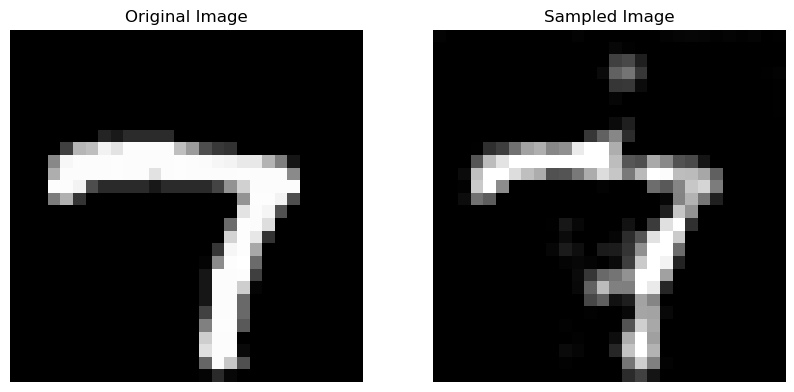

In [35]:
import torch
import matplotlib.pyplot as plt

# Load the saved data
sampled_data = torch.load('sampled_mnist_echo.pt')

# Access a specific entry
index = 18 # Replace with the index you want to check
original_image = sampled_data[index]['original_image']
sampled_image = sampled_data[index]['sampled']



# Convert the tensor to a numpy array
original_image = original_image.cpu().numpy().transpose(1, 2, 0)
sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(sampled_image, cmap='gray')
ax[1].set_title('Sampled Image')
ax[1].axis('off')

plt.show()